In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler

# Load your data
data = pd.read_excel('/content/drive/MyDrive/research_Mine/usgs.raritan.project.microcystin.nutrients.phytoplankton.xlsx', parse_dates=['sample_time', 'dateTime'])

# Columns to impute
cols_to_impute = ['microcystin_total_abraxis_ugL', 'Ammonia', 'Nitrate + Nitrite',
                  'Orthophosphate', 'Total nitrogen', 'Total Phosphorus', 'Inorg N',
                  '% Org N', '% Org P', 'Total_Cyanobacteria', 'Total_phytoplankton']

# 1. Create a complete date range
date_range = pd.date_range(start='2020-08-01', end='2021-08-01', freq='D')

# 2. Resample and impute for each site
imputed_data = []
for site in data['site_abbreviation'].unique():
    site_data = data[data['site_abbreviation'] == site].copy()
    site_data = site_data.set_index('dateTime')
    site_data = site_data.resample('D').last()

    for col in cols_to_impute:
        site_col_data = site_data[col].dropna()
        if len(site_col_data) > 5:
            scaler = MinMaxScaler()
            site_col_data_scaled = scaler.fit_transform(site_col_data.values.reshape(-1, 1))
            try:
                model = ARIMA(site_col_data_scaled, order=(5, 1, 0))
                model_fit = model.fit()
                missing_indices = site_data[site_data[col].isnull()].index
                if len(missing_indices) > 0:
                    predictions = model_fit.predict(start=len(site_col_data), end=len(site_col_data) + len(missing_indices) - 1)
                    imputed_values = scaler.inverse_transform(predictions.reshape(-1, 1))
                    site_data.loc[missing_indices, col] = imputed_values.flatten()
            except:
                print(f"ARIMA failed for site: {site}, column: {col}. Using forward fill.")
                site_data[col] = site_data[col].fillna(method='ffill')
        else:
            print(f"Not enough data for ARIMA for site: {site}, column: {col}. Using forward fill.")
            site_data[col] = site_data[col].fillna(method='ffill')
    imputed_data.append(site_data)

# 4. Combine imputed data
imputed_data = pd.concat(imputed_data)
imputed_data = imputed_data.reset_index()

# Fill remaining missing values using forward fill
for col in ['site_no', 'site_abbreviation', 'Individual']:
    imputed_data[col] = imputed_data[col].fillna(method='ffill')

imputed_data['sample_time'] = imputed_data['dateTime']
# Convert site_no to integer
imputed_data['site_no'] = imputed_data['site_no'].astype(int)
imputed_data.to_csv('imputed_data_daily_for_all_sites.csv', index=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/loc

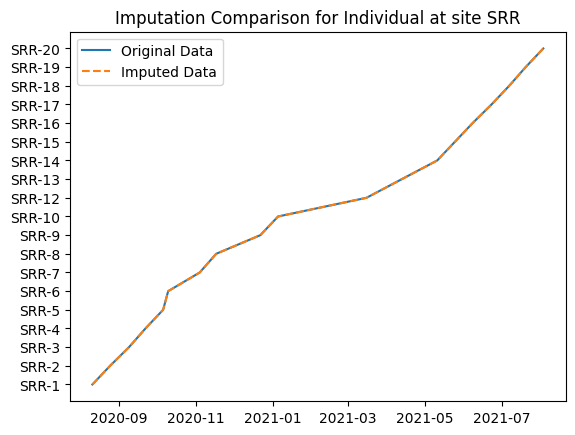

In [ ]:
import matplotlib.pyplot as plt # Import the matplotlib library

# site_col_data needs to be re-calculated for the current site and col outside the loop
site_col_data = site_data[col].dropna()

# Filter site_data to only include dates present in site_col_data
site_data_filtered = site_data[site_data.index.isin(site_col_data.index)]

plt.plot(site_col_data.index, site_col_data, label='Original Data') # Now site_col_data matches site_data's length
plt.plot(site_data_filtered.index, site_data_filtered[col], label='Imputed Data', linestyle='--')
plt.legend()
plt.title(f"Imputation Comparison for {col} at site {site}")
plt.show()


In [ ]:
data.columns

Index(['site_no', 'site_abbreviation', 'Individual', 'sample_time', 'dateTime',
       'microcystin_total_abraxis_ugL', 'Ammonia', 'Nitrate + Nitrite',
       'Orthophosphate', 'Total nitrogen', 'Total Phosphorus', 'Inorg N',
       '% Org N', '% Org P', 'Total_Cyanobacteria', 'Total_phytoplankton'],
      dtype='object')

In [4]:
import matplotlib.pyplot as plt

# Loop through a few key columns and sites for visual inspection
cols_to_check = ['microcystin_total_abraxis_ugL', 'Nitrate + Nitrite', 'Total Phosphorus']
sites_to_check = imputed_data['site_abbreviation'].unique()

for site in sites_to_check:
    for col in cols_to_check:
        site_data = imputed_data[imputed_data['site_abbreviation'] == site].copy()
        site_data.set_index('dateTime', inplace=True)

        original_data = site_data[col].copy()
        missing_mask = original_data.isnull()

        # Skip if there's no data to compare
        if missing_mask.sum() == 0 or missing_mask.sum() == len(original_data):
            continue

        # Plot known values and imputed values
        plt.figure(figsize=(10, 4))
        plt.plot(original_data.index, original_data, label='All Data', color='gray', alpha=0.4)

        known_values = original_data[~missing_mask]
        imputed_values = original_data[missing_mask]

        plt.plot(known_values.index, known_values, label='Known', color='blue')
        plt.plot(imputed_values.index, imputed_values, 'o', label='Imputed', color='red')

        plt.title(f'{col} - Site: {site}')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [5]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Select site and column
col = 'Total Phosphorus'
site = 'RR5'

# Get data for selected site
site_data = imputed_data[imputed_data['site_abbreviation'] == site].copy()
site_data.set_index('dateTime', inplace=True)

# Drop missing values
clean_data = site_data[col].dropna()

# Simulate missing data (hold out 20% of it)
test_indices = clean_data.sample(frac=0.2, random_state=42).sort_index().index # Get the index values
train_data = clean_data.drop(index=test_indices)

# ARIMA requires a numeric index, so reset it
train_values = train_data.values
test_values = test_indices.values  # For actual value comparison later

# Fit ARIMA
model = ARIMA(train_values, order=(3, 1, 0))
model_fit = model.fit()

# Predict the same number of steps as test points
start = len(train_values)
end = start + len(test_values) - 1
preds = model_fit.predict(start=start, end=end)

# Evaluate
rmse = np.sqrt(mean_squared_error(test_values, preds))
r2 = r2_score(test_values, preds)

print(f"RMSE: {rmse:.4f}")
print(f"R² score: {r2:.4f}")

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(test_indices.index, test_values, label='True Values', color='blue')
plt.plot(test_indices.index, preds, label='Predicted (Imputed)', linestyle='--', color='red')
plt.title(f"{col} - Imputation Simulation at Site {site}")
plt.legend()
plt.tight_layout()
plt.show()


RMSE: 1611551152972911104.0000
R² score: -31532.7854


AttributeError: 'DatetimeIndex' object has no attribute 'index'

<Figure size 1000x400 with 0 Axes>

RMSE: 42.9746
R² score: -0.1573


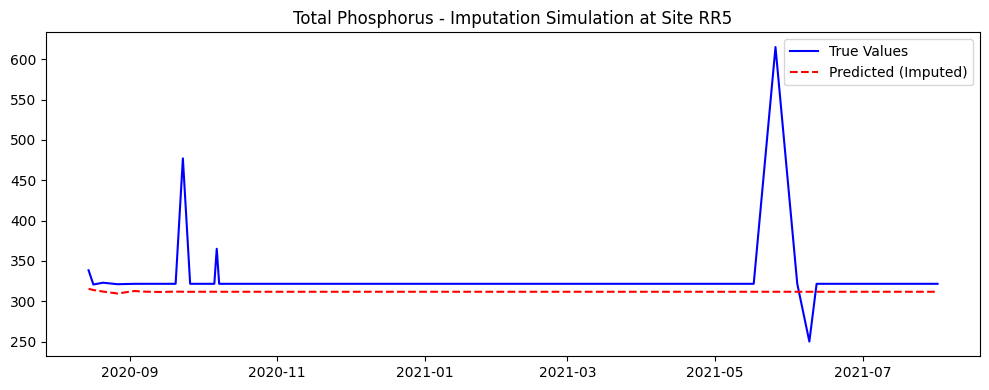

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Select site and column
col = 'Total Phosphorus'
site = 'RR5'

# Get data for selected site
site_data = imputed_data[imputed_data['site_abbreviation'] == site].copy()
site_data.set_index('dateTime', inplace=True)

# Drop missing values
clean_data = site_data[col].dropna()

# Simulate missing data (hold out 20% of it)
test_indices = clean_data.sample(frac=0.2, random_state=42).sort_index().index # Get the index values
train_data = clean_data.drop(index=test_indices)

# ARIMA requires a numeric index, so reset it
train_values = train_data.values
test_values = clean_data.loc[test_indices].values # Extract actual values for comparison

# Fit ARIMA
model = ARIMA(train_values, order=(3, 1, 0))
model_fit = model.fit()

# Predict the same number of steps as test points
start = len(train_values)
end = start + len(test_values) - 1
preds = model_fit.predict(start=start, end=end)

# Evaluate
rmse = np.sqrt(mean_squared_error(test_values, preds))
r2 = r2_score(test_values, preds)

print(f"RMSE: {rmse:.4f}")
print(f"R² score: {r2:.4f}")

# Plotting
plt.figure(figsize=(10, 4))
# Use test_indices directly for x-axis (it's already a DatetimeIndex)
plt.plot(test_indices, test_values, label='True Values', color='blue')
plt.plot(test_indices, preds, label='Predicted (Imputed)', linestyle='--', color='red')
plt.title(f"{col} - Imputation Simulation at Site {site}")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
##change the value of site_no 1400000 to 1396790
#imputed_data['site_no'] = imputed_data['site_no'].replace(1400000, 1396790)
#load imported daily data
import pandas as pd
data = pd.read_csv('/content/imputed_data_daily_for_all_sites.csv')
#check for null
data.isnull().sum()

,0
dateTime,0
site_no,0
site_abbreviation,0
Individual,0
sample_time,0
microcystin_total_abraxis_ugL,0
Ammonia,0
Nitrate + Nitrite,0
Orthophosphate,0
Total nitrogen,0


Load Data from NWIS for each site water temperature

In [ ]:
import requests
import pandas as pd

site_list = [
    '01400500', '01403060', '01396790', '01402000',
    '01401000', '01397000', '01396800', '01396500', '01396085'
]

start_date = '2020-08-01'
end_date = '2021-08-31'

rdb_data = []

for site in site_list:
    url = (
        f"https://nwis.waterservices.usgs.gov/nwis/dv/"
        f"?format=rdb&sites={site}&parameterCd=00010"
        f"&startDT={start_date}&endDT={end_date}"
    )
    try:
        resp = requests.get(url, timeout=10)
        status = resp.status_code
        text = resp.text
    except Exception as e:
        status = None
        text = str(e)

    rdb_data.append({'site_no': site, 'status_code': status, 'rdb_text': text})

df_rdb_text = pd.DataFrame(rdb_data)

# Save to CSV
df_rdb_text.to_csv("usgs_raw_rdb_temperature_2020_2021.csv", index=False)


In [ ]:
import requests
import pandas as pd
import io


# Load the raw data from CSV
df_rdb_text = pd.read_csv("usgs_raw_rdb_temperature_2020_2021.csv")

# Function to extract temperature from RDB text
def extract_temperature(rdb_text):
    try:
        # Skip comment lines and metadata
        lines = [line for line in rdb_text.splitlines()
                 if not line.startswith('#') and not line.lower().startswith('5s')]

        if len(lines) < 3:  # Check for valid data
            return None

        # Create DataFrame from remaining lines
        df = pd.read_csv(io.StringIO("\n".join(lines)), sep="\t", dtype=str)

        # Extract temperature column (may need adjustment based on actual data format)
        mean_col = [col for col in df.columns if col.endswith('_00010_00003')]
        if not mean_col:
            return None

        # Return the temperature values (assuming there's a 'datetime' column)
        return df[['datetime', mean_col[0]]].rename(columns={mean_col[0]: 'temperature_C'})

    except Exception as e:
        print(f"Error extracting temperature: {e}")
        return None

# Apply the extraction function to the 'rdb_text' column
df_rdb_text['temperature_data'] = df_rdb_text['rdb_text'].apply(extract_temperature)

# Drop rows with errors and irrelevant columns
df_temps = df_rdb_text.dropna(subset=['temperature_data']).drop(columns=['status_code', 'rdb_text'])

# Reshape the data to have site_no and temperature columns
all_temp_data = []
for index, row in df_temps.iterrows():
    site_no = row['site_no']
    temp_df = row['temperature_data']
    temp_df['site_no'] = site_no
    all_temp_data.append(temp_df)

final_df = pd.concat(all_temp_data, ignore_index=True)
print(final_df.head())
# Display the result
print(final_df[['datetime','site_no', 'temperature_C']])

#convert to CSV
final_df[['datetime','site_no', 'temperature_C']].to_csv("usgs_temperatures.csv", index=False)

     datetime temperature_C  site_no
0  2020-08-01          27.1  1400500
1  2020-08-02          28.1  1400500
2  2020-08-03          28.8  1400500
3  2020-08-04          25.7  1400500
4  2020-08-05          24.1  1400500
        datetime  site_no temperature_C
0     2020-08-01  1400500          27.1
1     2020-08-02  1400500          28.1
2     2020-08-03  1400500          28.8
3     2020-08-04  1400500          25.7
4     2020-08-05  1400500          24.1
...          ...      ...           ...
1869  2021-08-27  1396085          28.4
1870  2021-08-28  1396085          27.4
1871  2021-08-29  1396085          25.1
1872  2021-08-30  1396085          24.5
1873  2021-08-31  1396085           Dis

[1874 rows x 3 columns]


Read the Data from daily_STream flow from dataset https://www.sciencebase.gov/catalog/item/5f60d95e82ce3550e3c23133

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/research_Mine/daily_stream_temperature.csv')

<ipython-input-48-2421ac19e54c>:1: DtypeWarning: Columns (1,3,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/research_Mine/daily_stream_temperature.csv')


Trim the site_id from Temperature data of sites and only select data between 2020 to 2021

In [ ]:
siteonedf = df[
    df['site_id'].apply(lambda x: x in ['USGS-01400500', 'USGS-01403060', 'USGS-01396790', 'USGS-01402000',
    'USGS-01401000', 'USGS-01397000', 'USGS-01396800', 'USGS-01396500', 'USGS-01396085']) &
    pd.to_datetime(df['date']).dt.year.between(2020, 2021)
]

In [ ]:
import pandas as pd

# Remove 'USGS-' and 'USGS-0' from the start of 'site_id'
siteonedf['site_id'] = siteonedf['site_id'].str.replace(r'^USGS-0*', '', regex=True)

# Keep only required columns
siteonedf = siteonedf[['date', 'site_id', 'mean_temp_degC']]

# Rename columns
siteonedf.columns = ['datetime', 'site_no', 'temperature_C']

# Convert 'datetime' column to datetime format and keep only the date part
siteonedf['datetime'] = pd.to_datetime(siteonedf['datetime']).dt.date

# Convert back to datetime to ensure it's still a datetime object
siteonedf['datetime'] = pd.to_datetime(siteonedf['datetime'])

# Fill null values in temperature (choose method: here we use forward fill)
siteonedf['temperature_C'].fillna(method='ffill', inplace=True)

# Save the cleaned DataFrame to a CSV
siteonedf.to_csv("siteonedf.csv", index=False)

<ipython-input-50-f484c9a13c7f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  siteonedf['site_id'] = siteonedf['site_id'].str.replace(r'^USGS-0*', '', regex=True)
<ipython-input-50-f484c9a13c7f>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  siteonedf['datetime'] = pd.to_datetime(siteonedf['datetime']).dt.date
<ipython-input-50-f484c9a13c7f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [ ]:
import pandas as pd

# Load both datasets
df1 = pd.read_csv("siteonedf.csv")       # or your first temperature dataset
df2 = pd.read_csv("usgs_temperatures.csv")  # second dataset

# Merge on site_no and datetime
merged = pd.merge(
    df1,
    df2,
    on=['site_no', 'datetime'],
    how='outer',
    suffixes=('_df1', '_df2')
)

# Create unified temperature column, preferring df1 values if both exist
merged['temperature_C'] = merged['temperature_C_df1'].combine_first(merged['temperature_C_df2'])

# Drop the old temp columns
merged = merged.drop(columns=['temperature_C_df1', 'temperature_C_df2'])

# Sort by site and datetime (optional, but cleaner)
merged = merged.sort_values(by=['site_no', 'datetime'])

# Save the final merged result
merged.to_csv("merged_temperature_data.csv", index=False)

# Show first few rows
print(merged.head())

#select values from 2020-08-11 to 2021-08-03
merged = merged[(merged['datetime'] >= '2020-08-11') & (merged['datetime'] <= '2021-08-31')]

#convert to csv
merged.to_csv("merged_temperature_data1.csv", index=False)

     datetime  site_no temperature_C
0  2020-07-23  1396085          27.3
1  2020-07-24  1396085          27.0
2  2020-07-25  1396085          27.4
3  2020-07-26  1396085          27.5
4  2020-07-27  1396085          27.2


Make sure that temperature should be for all the sites if not fill it

In [ ]:
import pandas as pd

# Load merged temperature data
merged = pd.read_csv("merged_temperature_data1.csv")

# Convert datetime to datetime format
merged['datetime'] = pd.to_datetime(merged['datetime'])

# List of all target sites
target_sites = ['1400500', '1403060', '1396790', '1402000',
                '1401000', '1397000', '1396800', '1396500', '1396085']

# Make sure all site numbers are strings (to match)
merged['site_no'] = merged['site_no'].astype(str)

# Filter only the target sites (if more sites exist in data)
merged = merged[merged['site_no'].isin(target_sites)]

# Now: Reindex to include all site-date combinations
# Get all unique dates and create full index
all_dates = merged['datetime'].sort_values().unique()
full_index = pd.MultiIndex.from_product(
    [target_sites, all_dates],
    names=['site_no', 'datetime']
)

# Reindex the data to include all combinations
merged_full = merged.set_index(['site_no', 'datetime']).reindex(full_index).reset_index()

# Fill missing values within each site
# Reset index before groupby to avoid index mismatch
merged_full['temperature_C'] = merged_full.reset_index().groupby('site_no')['temperature_C'].apply(lambda x: x.ffill().bfill()).values

# Convert 'temperature_C' to numeric, handling errors
merged_full['temperature_C'] = pd.to_numeric(merged_full['temperature_C'], errors='coerce')

# Fill any remaining NaNs with the overall mean temperature
merged_full['temperature_C'] = merged_full['temperature_C'].fillna(merged_full['temperature_C'].mean())

# Save final cleaned version
merged_full.to_csv("cleaned_temperature_data.csv", index=False)

# Check for any remaining nulls
null_counts = merged_full['temperature_C'].isnull().sum()
print(f"Total null values after filling: {null_counts}")

# Preview
print(merged_full.head())

Total null values after filling: 0
   site_no   datetime  temperature_C
0  1400500 2020-08-11           26.4
1  1400500 2020-08-12           28.2
2  1400500 2020-08-13           28.4
3  1400500 2020-08-14           27.6
4  1400500 2020-08-15           26.9


Final STep: Merge Temperature data to the imputed_Daily_date for all sites from Aug 2020 to Aug 2021

In [ ]:
import pandas as pd

# Load both datasets
temp_df = pd.read_csv("cleaned_temperature_data.csv")
eimputed_df = pd.read_csv("/content/imputed_data_daily_for_all_sites.csv")

#convert this emputed daily data value for site_no from 1396085.0 to 1396085
eimputed_df['site_no'] = eimputed_df['site_no'].astype(int)
#eimputed_df['site_no'] = eimputed_df['site_no'].astype(str)

# Rename datetime column to dateTime
temp_df.rename(columns={'datetime': 'dateTime'}, inplace=True)
# Ensure date columns are in datetime format (if applicable)
temp_df['dateTime'] = pd.to_datetime(temp_df['dateTime'])
eimputed_df['dateTime'] = pd.to_datetime(eimputed_df['dateTime'])

# Ensure site_no is a string in both
temp_df['site_no'] = temp_df['site_no'].astype(str)
eimputed_df['site_no'] = eimputed_df['site_no'].astype(str)

# Merge on site_no and datetime
merged_df = pd.merge(
    eimputed_df,
    temp_df[['site_no', 'dateTime', 'temperature_C']],
    on=['site_no', 'dateTime'],
    how='left'  # Keeps all Eimputed rows even if temp is missing
)

# Save the merged result
merged_df.to_csv("final_usgs_imputed_data_with_temperature.csv", index=False)


#check for null or nan

print(merged_df.isna().sum())

#unique site+no numbers in eimputed
print(eimputed_df['site_no'].unique())

dateTime                         0
site_no                          0
site_abbreviation                0
Individual                       0
sample_time                      0
microcystin_total_abraxis_ugL    0
Ammonia                          0
Nitrate + Nitrite                0
Orthophosphate                   0
Total nitrogen                   0
Total Phosphorus                 0
Inorg N                          0
% Org N                          0
% Org P                          0
Total_Cyanobacteria              0
Total_phytoplankton              0
temperature_C                    0
dtype: int64
['1396085' '1396500' '1396800' '1397000' '1401000' '1402000' '1400500'
 '1403060' '1396790']
